In [41]:
import json
import matplotlib.pyplot as plt
import torch
colors = ['red', 'blue', 'green', 'yellow', 'purple', 'orange', 'cyan']
# name_list = ['tst-rl-gpt2-xl.json', 'tst-dpo-gpt2-xl.json', 'tst-dpo-multi-gpt2-xl.json']
# save_dir = '/hpcgpfs01/scratch/gzhao/rl-prompt/examples/text-style-transfer/outputs/2024-03-22'
# name_list = ['outputs/2024-03-27/15-30-10tst-ipo-gpt2-xl', 
#              'outputs/2024-03-27/15-29-39tst-rl-gpt2-xl', 
#              'outputs/2024-03-27/15-29-00tst-ipo-multi-gpt2-xl'
#              ]
save_dir = '/hpcgpfs01/scratch/gzhao/rl-prompt/examples/text-style-transfer'

def find_pareto_front(samples):
    """
    Find the Pareto front of given sample points.
    
    :param samples: Torch tensor of size N*2 containing sample points (N samples, 2 objectives).
    :return: Pareto front as a torch tensor.
    """
    pareto_front = []
    dominated_by = torch.zeros(samples.size(0), dtype=torch.bool)
    
    for idx, point1 in enumerate(samples):
        if not dominated_by[idx]:
            pareto_front.append(idx)
            for j, point2 in enumerate(samples):
                if idx != j:
                    if torch.all(point1 >= point2):
                        dominated_by[j] = True
                    elif torch.all(point1 <= point2):
                        dominated_by[idx] = True
                        pareto_front.remove(idx)
                        break
    pareto_front_tensor = samples[pareto_front]
    
    return pareto_front_tensor

def calculate_dominating_volume(pareto_front, ref_point):
    """
    Calculate the dominating volume of the Pareto front with respect to a reference point.
    
    :param pareto_front: Torch tensor of size N*2 containing points in the Pareto front (N points, 2 objectives).
    :param ref_point: Torch tensor of size 2 representing the reference point.
    :return: Dominating volume of the Pareto front.
    """
    # Sort Pareto front based on the first objective (ascending order)
    sorted_pareto_front = pareto_front[pareto_front[:, 0].argsort()]
    
    # Initialize dominating volume
    dominating_volume = 0.0
    
    # Initialize the upper left corner of the rectangle
    upper_left_corner = ref_point.clone()
    
    # Iterate through sorted Pareto front
    for point in sorted_pareto_front:
        # Calculate the width and height of the rectangle
        width = point[0] - upper_left_corner[0]  
        height = point[1] - upper_left_corner[1]  
        
        # Update dominating volume by adding the area of the rectangle
        dominating_volume += width * height
        
        # Update the upper left corner for the next rectangle
        upper_left_corner[0] = point[0]
    
    return dominating_volume

In [88]:
import os
file_list = os.listdir("/hpcgpfs01/scratch/gzhao/rl-prompt/examples/text-style-transfer/outputs/2024-05-19")
json_files = ["outputs/2024-05-19/"+file for file in file_list if file.endswith('.json')]
file_list = os.listdir("/hpcgpfs01/scratch/gzhao/rl-prompt/examples/text-style-transfer/outputs/2024-05-20")
json_files += ["outputs/2024-05-20/"+file for file in file_list if file.endswith('.json')]
file_list = os.listdir("/hpcgpfs01/scratch/gzhao/rl-prompt/examples/text-style-transfer/outputs/2024-05-21")
json_files += ["outputs/2024-05-21/"+file for file in file_list if file.endswith('.json')]
# file_list = os.listdir("/hpcgpfs01/scratch/gzhao/rl-prompt/examples/text-style-transfer/outputs/2024-05-22")
# json_files += ["outputs/2024-05-22/"+file for file in file_list if file.endswith('.json')]


In [89]:
label_list = ('RlPrompt', "HVI", "Reward-Guided DPO", "Reward-Guided IPO", "Dominance-Only DPO", "Dominance-Only IPO", "ParetoPrompt DPO", "ParetoPrompt IPO")
all_files = [[]]*8
all_files[0] = [file for file in json_files if "rlprompt" in file]
all_files[1] = [file for file in json_files if "hypervolume" in file]
all_files[2] = [file for file in json_files if "single_dpo" in file]
all_files[3] = [file for file in json_files if "single_ipo" in file]
all_files[4] = [file for file in json_files if "multi_nond_dpo" in file]
all_files[5] = [file for file in json_files if "multi_nond_ipo" in file] + ['outputs/2024-03-30/12-42-07tst-ipo-multi-gpt2-xl-0.1lr.json']
all_files[6] = [file for file in json_files if "multi_probdiff_dpo" in file]
all_files[7] = [file for file in json_files if "multi_probdiff_ipo" in file]

In [38]:
all_files[5] = all_files[5].pop(1)

In [90]:
import os
from collections import defaultdict
paper_dict = defaultdict(dict)
for i in range(0, 8):
    name_list = all_files[i]
    
    temp_dict = defaultdict(list)
    
    for j, name in enumerate(name_list):
        file_name = os.path.join(save_dir, name)
        with open(file_name) as f:
            performance = json.load(f)
        for key in performance.keys():
            content = torch.tensor(performance[key]['content'])
            style = torch.tensor(performance[key]['style'])
            samples = torch.stack((content, style), dim=1)
            pareto_front_tensor = find_pareto_front(samples)

            # Reference point (torch tensor of size 2)
            reference_point = torch.tensor([.0, .0])

            # Calculate dominating volume
            dominating_volume = calculate_dominating_volume(pareto_front_tensor, reference_point)
            performance[key]['dominating_volume']=dominating_volume
            performance[key]['content'] = content
            performance[key]['style'] = style
        
        
        temp_dict['content'].append(content)
        temp_dict['style'].append(style)
        temp_dict['dominating_volume'].append(dominating_volume)
        temp_dict['samples'].append(samples)
        paper_dict[label_list[i]] = temp_dict
            

In [35]:
paper_dict[label_list[5]]['dominating_volume']

[tensor(2693.1509),
 tensor(3156.2339),
 tensor(1907.0020),
 tensor(1615.2196),
 tensor(3110.0251),
 tensor(2327.2649)]

In [91]:
content_list = []
style_list = []
for i in paper_dict.keys():
    content_list+=paper_dict[i]['content']
    style_list+=paper_dict[i]['style']
content0 = torch.cat(content_list)
style0 = torch.cat(style_list)
samples = torch.stack((content0, style0), dim=1)
pareto_front_tensor0 = find_pareto_front(samples)

In [93]:
import numpy as np
from pymoo.indicators.igd import IGD
# The pareto front of a scaled zdt1 problem
pf = np.array(pareto_front_tensor0)
ind = IGD(pf)
for i in paper_dict.keys():
    print(i)
    
    for bb in paper_dict[i]['samples']:
        A = np.array(bb)
        paper_dict[i]['IGD'].append(ind(A))

RlPrompt
HVI
Reward-Guided DPO
Reward-Guided IPO
Dominance-Only DPO
Dominance-Only IPO
ParetoPrompt DPO
ParetoPrompt IPO


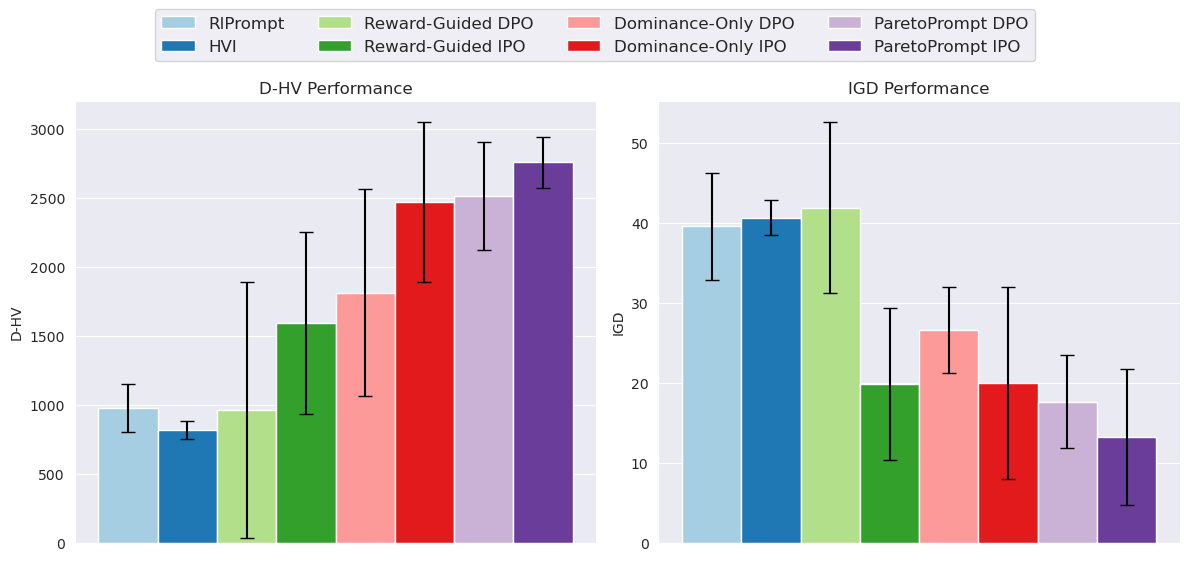

In [100]:
import matplotlib.pyplot as plt
import numpy as np

# Example data
models = label_list
metrics = ['D-HV', 'IGD']
performance = {}
variances = {}
max_domin = 0
max_igd = 0
for l in models:
    max_domin = max(np.array(paper_dict[l]['dominating_volume']).max(), max_domin)
    max_igd = max(np.array(paper_dict[l]['IGD']).max(), max_igd)


for l in models:
    # if l in models[:2]:
    #     performance[l] = [0, 0]
    #     variances[l] = [0, 0]
    #     continue
    domin = np.array(paper_dict[l]['dominating_volume'])
    igdarray = np.array(paper_dict[l]['IGD'])
    performance[l] = [domin.mean(), igdarray.mean()]
    variances[l] = [domin.std(), igdarray.std()]
import seaborn as sns
sns.set_style("dark")

# Number of models and metrics
num_models = len(models)
num_metrics = len(metrics)

# Set up the bar width and positions
bar_width = 0.1  # Adjust bar width to fit all bars
index = np.arange(num_metrics)

# Plot bars for each model with error bars
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
colors = sns.color_palette("Paired")

# Plot bars for the first metric (D-HV) in the first subplot
for i, model in enumerate(models):
    ax1.bar(index[0] + i * bar_width, performance[model][0], bar_width,
            yerr=variances[model][0], label=model, capsize=5, color=colors[i] if i < 6 else colors[i + 2])
ax1.set_title('D-HV Performance')
ax1.set_xticks([])
#ax1.set_xticks([index[0] + bar_width * (num_models - 1) / 2])
#ax1.set_xticklabels([metrics[0]])
ax1.set_ylabel('D-HV')
# ax1.legend()

# Plot bars for the second metric (IGD) in the second subplot
for i, model in enumerate(models):
    ax2.bar(index[1] + i * bar_width, performance[model][1], bar_width,
            yerr=variances[model][1], label=model, capsize=5, color=colors[i] if i < 6 else colors[i + 2])
ax2.set_title('IGD Performance')
ax2.set_xticks([])
#ax2.set_xticklabels([metrics[1]])
ax2.set_ylabel('IGD')
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=4, bbox_to_anchor=(0.5, 1.13), fontsize=12)

# Adjust the layout
ax1.grid()
ax2.grid()
fig.tight_layout()
plt.savefig('performance.pdf', bbox_inches='tight')
plt.show()


# for i, model in enumerate(models):
#     plt.bar(index + i * bar_width, performance[model], bar_width,
#             yerr=variances[model], label=model, capsize=5, color=colors[i] if i<6 else colors[i+2])

# # Add labels, title, and legend
# ax.set_xticks(index + bar_width * (num_models - 1) / 2)
# ax.set_xticklabels(metrics)
# plt.legend(fontsize=12)
# plt.grid()
# # Display the plot
# plt.savefig('performance.pdf', bbox_inches='tight')
# plt.show()


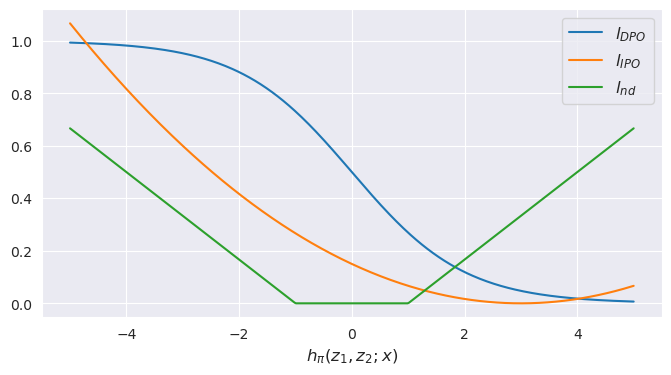

In [107]:
import numpy as np
import matplotlib.pyplot as plt

# Define the sigmoid function
def sigmoid(x):
    return -1 / (1 + np.exp(-x))+1

# Generate x values from -10 to 10
x = np.linspace(-5, 5, 400)
y = sigmoid(x)

y2 = (x-3)**2/60
y3 = np.maximum(np.abs(x)-1, 0)/6
colors = sns.color_palette("hls", 8)
# Plot the sigmoid function
plt.figure(figsize=(8, 4))
plt.plot(x, y, label='$l_{DPO}$')
plt.plot(x, y2, label='$l_{IPO}$')
plt.plot(x, y3, label='$l_{nd}$')
plt.xlabel('$h_\pi(z_1, z_2; x)$', fontsize=12)
plt.grid(True)
plt.legend(fontsize=12)
plt.grid(True)
plt.savefig('loss.pdf', bbox_inches='tight')
plt.show()

In [62]:
#paper draw
name_list = [
    "outputs/2024-05-20/22-12-15tst-rlprompt-gpt2-xl-0.1lr", 
    "outputs/2024-05-21/10-08-39tst-hypervolume", 
    "outputs/2024-05-19/16-12-30tst-ipo-multi-prob_diff-gpt2-xl-e0.1-tussingle_dpo", #reward dpo 
    "outputs/2024-05-19/15-24-23tst-ipo-multi-prob_diff-gpt2-xl-e0.1-tussingle_ipo", #reward ipo
    "outputs/2024-05-18/23-40-11tst-ipo-multi-gpt2-xl-0.1lr",  #dominant only IPO
    "outputs/2024-05-19/16-13-29tst-ipo-multi-prob_diff-gpt2-xl-e0.1-tusmulti_nond_dpo", #dominant only DPO
    "outputs/2024-04-26/15-43-03tst-ipo-multi-prob_diff-gpt2-xl-e0.1-tus200", #paretoprompt IPO
    "outputs/2024-05-19/15-25-58tst-ipo-multi-prob_diff-gpt2-xl-e0.1-tusmulti_probdiff_dpo" , #PP dpo
    # "outputs/2024-03-30/12-42-07tst-ipo-multi-gpt2-xl-0.1lr"
    # "outputs/2024-05-19/14-34-04tst-dpo-multi-noND-gpt2-xl-0.1lr", 
    # "outputs/2024-05-20/15-54-50tst-ipo-multi-gpt2-xl-0.1lr",# reinforce with rlprompt
]
# result_dict
# first layer names are run_names
# under each run_name are iteration names
# third layer names: content, style, dominating_volume
import os
from collections import defaultdict
result_dict = defaultdict(dict)
for j, name in enumerate(name_list):
    file_name = os.path.join(save_dir, name) + '.json'
    with open(file_name) as f:
        performance = json.load(f)
    for key in performance.keys():
        content = torch.tensor(performance[key]['content'])
        style = torch.tensor(performance[key]['style'])
        samples = torch.stack((content, style), dim=1)
        pareto_front_tensor = find_pareto_front(samples)

        # Reference point (torch tensor of size 2)
        reference_point = torch.tensor([.0, .0])

        # Calculate dominating volume
        dominating_volume = calculate_dominating_volume(pareto_front_tensor, reference_point)
        
        performance[key]['dominating_volume']=dominating_volume
        performance[key]['content'] = content
        performance[key]['style'] = style
    result_dict[name] = performance

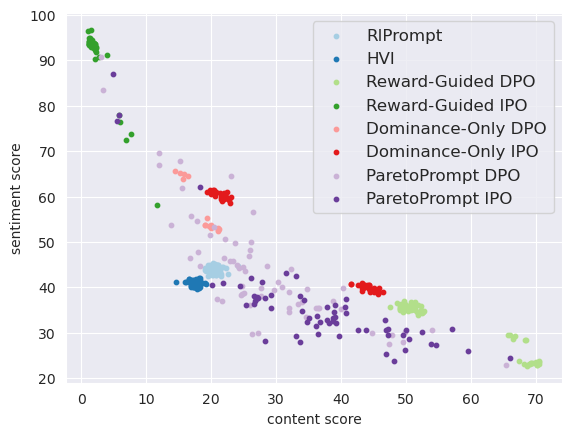

In [86]:
sns.set_style("dark")
for j, name in enumerate(name_list):
    for i in list(result_dict[name].keys())[-1:]:
        
        content = result_dict[name][i]['content']
        style = result_dict[name][i]['style']
        
        # name = name.split('/')[-1][8:]+i
        plt.scatter(content, style, color=colors[j if j<6 else j+2], label=label_list[j], s=10)
        j+=1
    # for t, (content, style) in enumerate(zip(performance[i]['content'], performance[i]['style'])):
    #     plt.scatter(content, style, color=colors[j], label=name if t==0 else None)
plt.xlabel('content score')
plt.ylabel('sentiment score')
# plt.scatter(pareto_front_tensor0[:, 0], pareto_front_tensor0[:, 1], color='k', s=50)

plt.legend(fontsize=12)
plt.grid()
plt.savefig('cluster.pdf', bbox_inches='tight')
plt.show()

In [69]:
name_list = [
    "outputs/2024-04-26/15-41-51tst-ipo-multi-prob_diff-gpt2-xl-e0.1-tus100", 
    "outputs/2024-04-26/15-43-03tst-ipo-multi-prob_diff-gpt2-xl-e0.1-tus200",
"outputs/2024-04-26/15-43-05tst-ipo-multi-prob_diff-gpt2-xl-e0.1-tus500",

]
import os
from collections import defaultdict
result_dict = defaultdict(dict)
for j, name in enumerate(name_list):
    file_name = os.path.join(save_dir, name) + '.json'
    with open(file_name) as f:
        performance = json.load(f)
    for key in performance.keys():
        content = torch.tensor(performance[key]['content'])
        style = torch.tensor(performance[key]['style'])
        samples = torch.stack((content, style), dim=1)
        pareto_front_tensor = find_pareto_front(samples)

        # Reference point (torch tensor of size 2)
        reference_point = torch.tensor([.0, .0])

        # Calculate dominating volume
        dominating_volume = calculate_dominating_volume(pareto_front_tensor, reference_point)
        
        performance[key]['dominating_volume']=dominating_volume
        performance[key]['content'] = content
        performance[key]['style'] = style
        A = np.array(samples)
        performance[key]['IGD'] = ind(A)
    result_dict[name] = performance

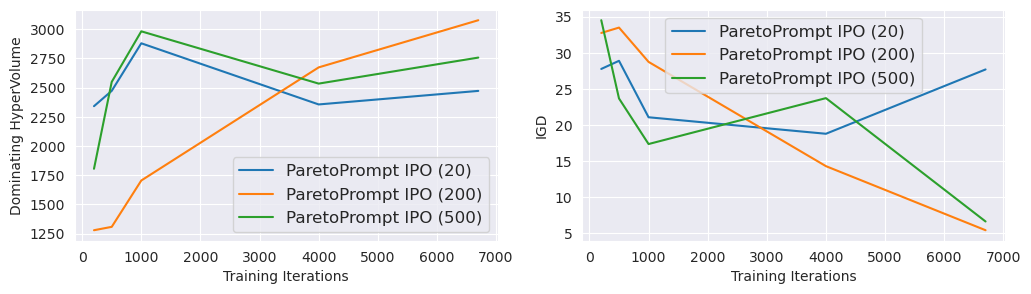

In [78]:
import matplotlib.pyplot as plt
label_list = ["ParetoPrompt IPO (20)", "ParetoPrompt IPO (200)", "ParetoPrompt IPO (500)"]
# Create the subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))

# Plot data for ax1
for j, name in enumerate(name_list):
    linex = []
    liney = []
    for i in result_dict[name].keys():
        linex.append(int(i))
        liney.append(result_dict[name][i]['dominating_volume'])
    name = name.split('/')[-1][8:]
    ax1.plot(linex, liney, label=label_list[j])
        
ax1.legend(fontsize=12)
ax1.set_ylabel("Dominating HyperVolume")
ax1.set_xlabel("Training Iterations")
ax1.grid()
# Plot data for ax2
for j, name in enumerate(name_list):
    linex = []
    liney = []
    for i in result_dict[name].keys():
        linex.append(int(i))
        liney.append(result_dict[name][i]['IGD'])
    name = name.split('/')[-1][8:]
    ax2.plot(linex, liney, label=label_list[j])
        
ax2.legend(fontsize=12)
ax2.set_ylabel("IGD")
ax2.set_xlabel("Training Iterations")
ax2.grid()
plt.savefig('ablation.pdf', bbox_inches='tight')
# Show the plot
plt.show()